# Challenge MeLi

Para resolver el challenge de MeLi se solicita seleccionar un caso de uso, de las opciones presentadas el caso que se seleccionó es el siguiente:

- El equipo comercial quiere realizar estrategias focalizadas para los sellers, pero en
este momento no existe una clasificación que permita identificar a aquellos que tienen
un buen perfil y son relevantes para el negocio. ¿Cómo podrías ayudar al equipo
comercial a identificar estos sellers?


Para responder esta pregunta se presenta el siguiente notebook con una solución para el challenge.

### Dependencias 

Primero para la ejecuión de manera correcta se deben instalar las librerías que se utilizaron para el challenge.

Para esto se deben instalar con **pip**, cabe destacar que las librerías estan detalladas en el archivo **requirements.txt**

In [2]:
%pip install -r requirements.txt

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/5c/e9/ee572691a3fb05555bcde41826faad29ae4bc1fb07982e7f53d54a176879/scikit_learn-1.3.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/28/08/9dcdaa5aac4634e4c23af26d92121f7ce445c630efa0d3037881ae2407fb/joblib-1.3.1-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 9.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 26.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


### Import librerías
Importamos las librerias y las funciones de extracción de datos declaradas en archivos externos del notebook. 

Las funciones se detallaran en el paso siguiente.


In [52]:
from data import get_categories, get_payment_type, get_items_by_cat
from constants import countries
from pandas import DataFrame, read_csv
import seaborn as sns
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np

### Extracción de datos

Para la extracción de datos se crearon distintas funciones con objetivos específicos según los datos y la url objetivo.

Los detalles de las funciones son los siguiemntes:

- **get_categories()**:
    Obtiene las categorias desde la api y entrega la información dentro de un dataframe.

- **get_items_by_cat(category, country)**:
    Obtiene los items de una categoria dada una categoría y un país en específico.

    
Primero se declara el nombre del archivo en donde almacenaremos los datos para no osbrecargar los servidor en caso de volver a ejecutar el script.
Luego se revisa si existe el archivo con los datos ya descargados, si no existe se realiza la descarga de datos.

La extracción primero obtienen las categorias y con eso se itera el objeto para obtener cerca de 1000 items por cada categoría obtenida categoría.

La API de busqueda de items entrega un json con información relacionada a cada registro en formato json por lo que cada registro obtenido se mapea para generar un diccionario con la información a utilizar.


In [3]:

file_name = 'data/items.csv'
if not os.path.exists(file_name):
    country_cl = 'MLC'
    categories = get_categories()
    cat_cl = categories[categories['country'] == country_cl]

    data_items = []
    for cat in cat_cl.itertuples():
        data_res = get_items_by_cat(cat[1], country_cl)
        data_items.extend(data_res)
    df_items = DataFrame.from_records(data_items)
else: 
    df_items = read_csv(file_name, sep=';')

/tmp/ipykernel_6493/1157492322.py:13: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df_items = read_csv(file_name, sep=';')


Vemos los nombres de las columnas y la información que se obtiene desde la API.

In [5]:
# df_items.to_csv('data/items.p', sep=';', index=False)
df_items.columns.values

array(['id', 'title', 'condition', 'listing_type_id', 'permalink',
       'site_id', 'category_id', 'domain_id', 'thumbnail', 'currency_id',
       'price', 'original_price', 'sale_price', 'sold_quantity',
       'available_quantity', 'official_store_id', 'use_thumbnail_id',
       'accepts_mercadopago', 'tags', 'shipping_store_pick_up',
       'shipping_free_shipping', 'shipping_logistic_type',
       'shipping_mode', 'shipping_tags', 'shipping_benefits',
       'shipping_promise', 'seller_id', 'seller_nickname',
       'seller_car_dealer', 'seller_real_estate_agency',
       'seller_registration_date', 'seller_car_dealer_logo',
       'seller_permalink', 'seller_level_id',
       'seller_power_seller_status', 'seller_transactions_canceled',
       'seller_transactions_completed', 'seller_rating_negative',
       'seller_rating_neutral', 'seller_rating_positive',
       'seller_transactions_total', 'address_state_id',
       'address_state_name', 'address_city_id', 'address_city_name'

### Análisis datos
Vemos una pequeña descripción de los datos para ver el tipo de dato que son.

In [21]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31037 entries, 0 to 31036
Data columns (total 52 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             31037 non-null  object 
 1   title                          31037 non-null  object 
 2   condition                      30037 non-null  object 
 3   listing_type_id                31037 non-null  object 
 4   permalink                      31037 non-null  object 
 5   site_id                        31037 non-null  object 
 6   category_id                    31037 non-null  object 
 7   domain_id                      31037 non-null  object 
 8   thumbnail                      31030 non-null  object 
 9   currency_id                    30396 non-null  object 
 10  price                          30396 non-null  float64
 11  original_price                 9633 non-null   float64
 12  sale_price                     0 non-null     

Reviso los datos nulos en cada columna del dataframe.

In [6]:
df_items.isnull().sum()

id                                   0
title                                0
condition                         1000
listing_type_id                      0
permalink                            0
site_id                              0
category_id                          0
domain_id                            0
thumbnail                            7
currency_id                        641
price                              641
original_price                   21404
sale_price                       31037
sold_quantity                        0
available_quantity                   0
official_store_id                26199
use_thumbnail_id                     0
accepts_mercadopago                  0
tags                                 0
shipping_store_pick_up               0
shipping_free_shipping               0
shipping_logistic_type             667
shipping_mode                        0
shipping_tags                        0
shipping_benefits                31037
shipping_promise         

En el contexto de la búsqueda de información relacionada con los sellers de MeLi hay varias variables que no son relevantes, sin embargo una variable que es primordial es el precio de los productos vendidos dentro de la plataforma. Aquí se puede ver que existen 641 productos que no cuentan con valor en ese campo.

Revisamos los campos que tienen precio

In [19]:
df_items[df_items['price'].isnull()][['permalink','category_id', 'domain_id']]

,permalink,category_id,domain_id
27037,https://servicio.mercadolibre.cl/MLC-132929747...,MLC9115,MLC-OTHER_SERVICES
27039,https://fiesta-evento.mercadolibre.cl/MLC-1357...,MLC9140,MLC-ILUMINATION_DJ_AND_MUSIC_EQUIPMENT_RENTAL_...
27040,https://fiesta-evento.mercadolibre.cl/MLC-1359...,MLC91912,MLC-OTHER_SERVICES
27041,https://servicio-tecnico.mercadolibre.cl/MLC-1...,MLC8977,MLC-AIR_CONDITIONERS_INSTALLATION_AND_REPAIR_S...
27042,https://fiesta-evento.mercadolibre.cl/MLC-1308...,MLC91912,MLC-OTHER_SERVICES
...,...,...,...
28032,https://servicio.mercadolibre.cl/MLC-173092348...,MLC9015,MLC-TRANSPORT_SERVICES
28033,https://servicio-tecnico.mercadolibre.cl/MLC-1...,MLC9019,MLC-OTHER_SERVICES
28034,https://servicio.mercadolibre.cl/MLC-138514703...,MLC93872,MLC-AUTOMOTIVE_TRANSMISSION_REPAIR_SERVICES
28035,https://servicio.mercadolibre.cl/MLC-135314163...,MLC9046,MLC-COURSES_AND_CLASSES_SERVICES


Al revisar los link para ver que tienen en común esos items vemos que las páginas no existen.

__Parece que esta página no existe__

Por lo anterior sacamos estos registros de los datos que se van a utilizar y generamos una copia con los datos.

In [24]:
df_items_valid = df_items[df_items['price'].notna()].copy()

Una de las variables que nos puede interesar para obtener información de los sellers es su categorización.

Por lo que revisamos los valores que trae

In [26]:
df_items_valid['seller_level_id'].unique()

array(['5_green', '3_yellow', '4_light_green', nan, '2_orange', '1_red'],
      dtype=object)

Como son pocos sus valores, generamos un mapeo con un valor numérico asociado a cada valor categórico para su posterior tratamiento.

In [27]:
# map to integer level seller
map_seller_level = {'5_green':5, '3_yellow':3, '4_light_green':4, '2_orange':2, '1_red':1}
df_items_valid['seller_level_value'] = df_items_valid['seller_level_id'].map(map_seller_level)
df_items_valid['seller_level_value'].fillna(0, inplace=True)

### Procesamiento Datos

Finalmente, seleccionamos los valores que nos parecen más apropiados para una caracterización de un seller dentro de los valores disponibles y agrupamos por seller_id para obtener datos de cada seller.

En este paso se quiso tomar como referencia el método RMF (recency, frequency, monetary) para caracterizar a cada seller sin embargo no pude encontrar dentro de la api y de las variables obtenidas algún información sobre la última compra que se realizo al seller. Por otro lado para la variable de monto monetario se genero a través multiplicación del promedio de precio de sus productos por la cantidad de total de productos vendidos y la la frecuencia se tomo como la cantidad total de productos vendidos. Esto es sólo una aproximación al método ya mencionado. Además, se tomo en cuenta el promedio de las calificaciones positivas, negativas y neutrales de cada seller y el promedio del nivel mapeado en el paso anterior

In [31]:

#RMF
group_by_seller = df_items_valid.groupby('seller_id').agg({
    'seller_rating_negative': 'mean',
    'seller_rating_neutral': 'mean',
    'seller_rating_positive': 'mean',
    'price': 'mean', 
    'seller_level_value': 'mean',
    'seller_transactions_canceled': 'sum',
    'sold_quantity': 'sum'
})
group_by_seller['monetary_mount'] = group_by_seller['price'] * group_by_seller['sold_quantity']


Para ver una representación visual de la relación generamos un gráfico de pares.

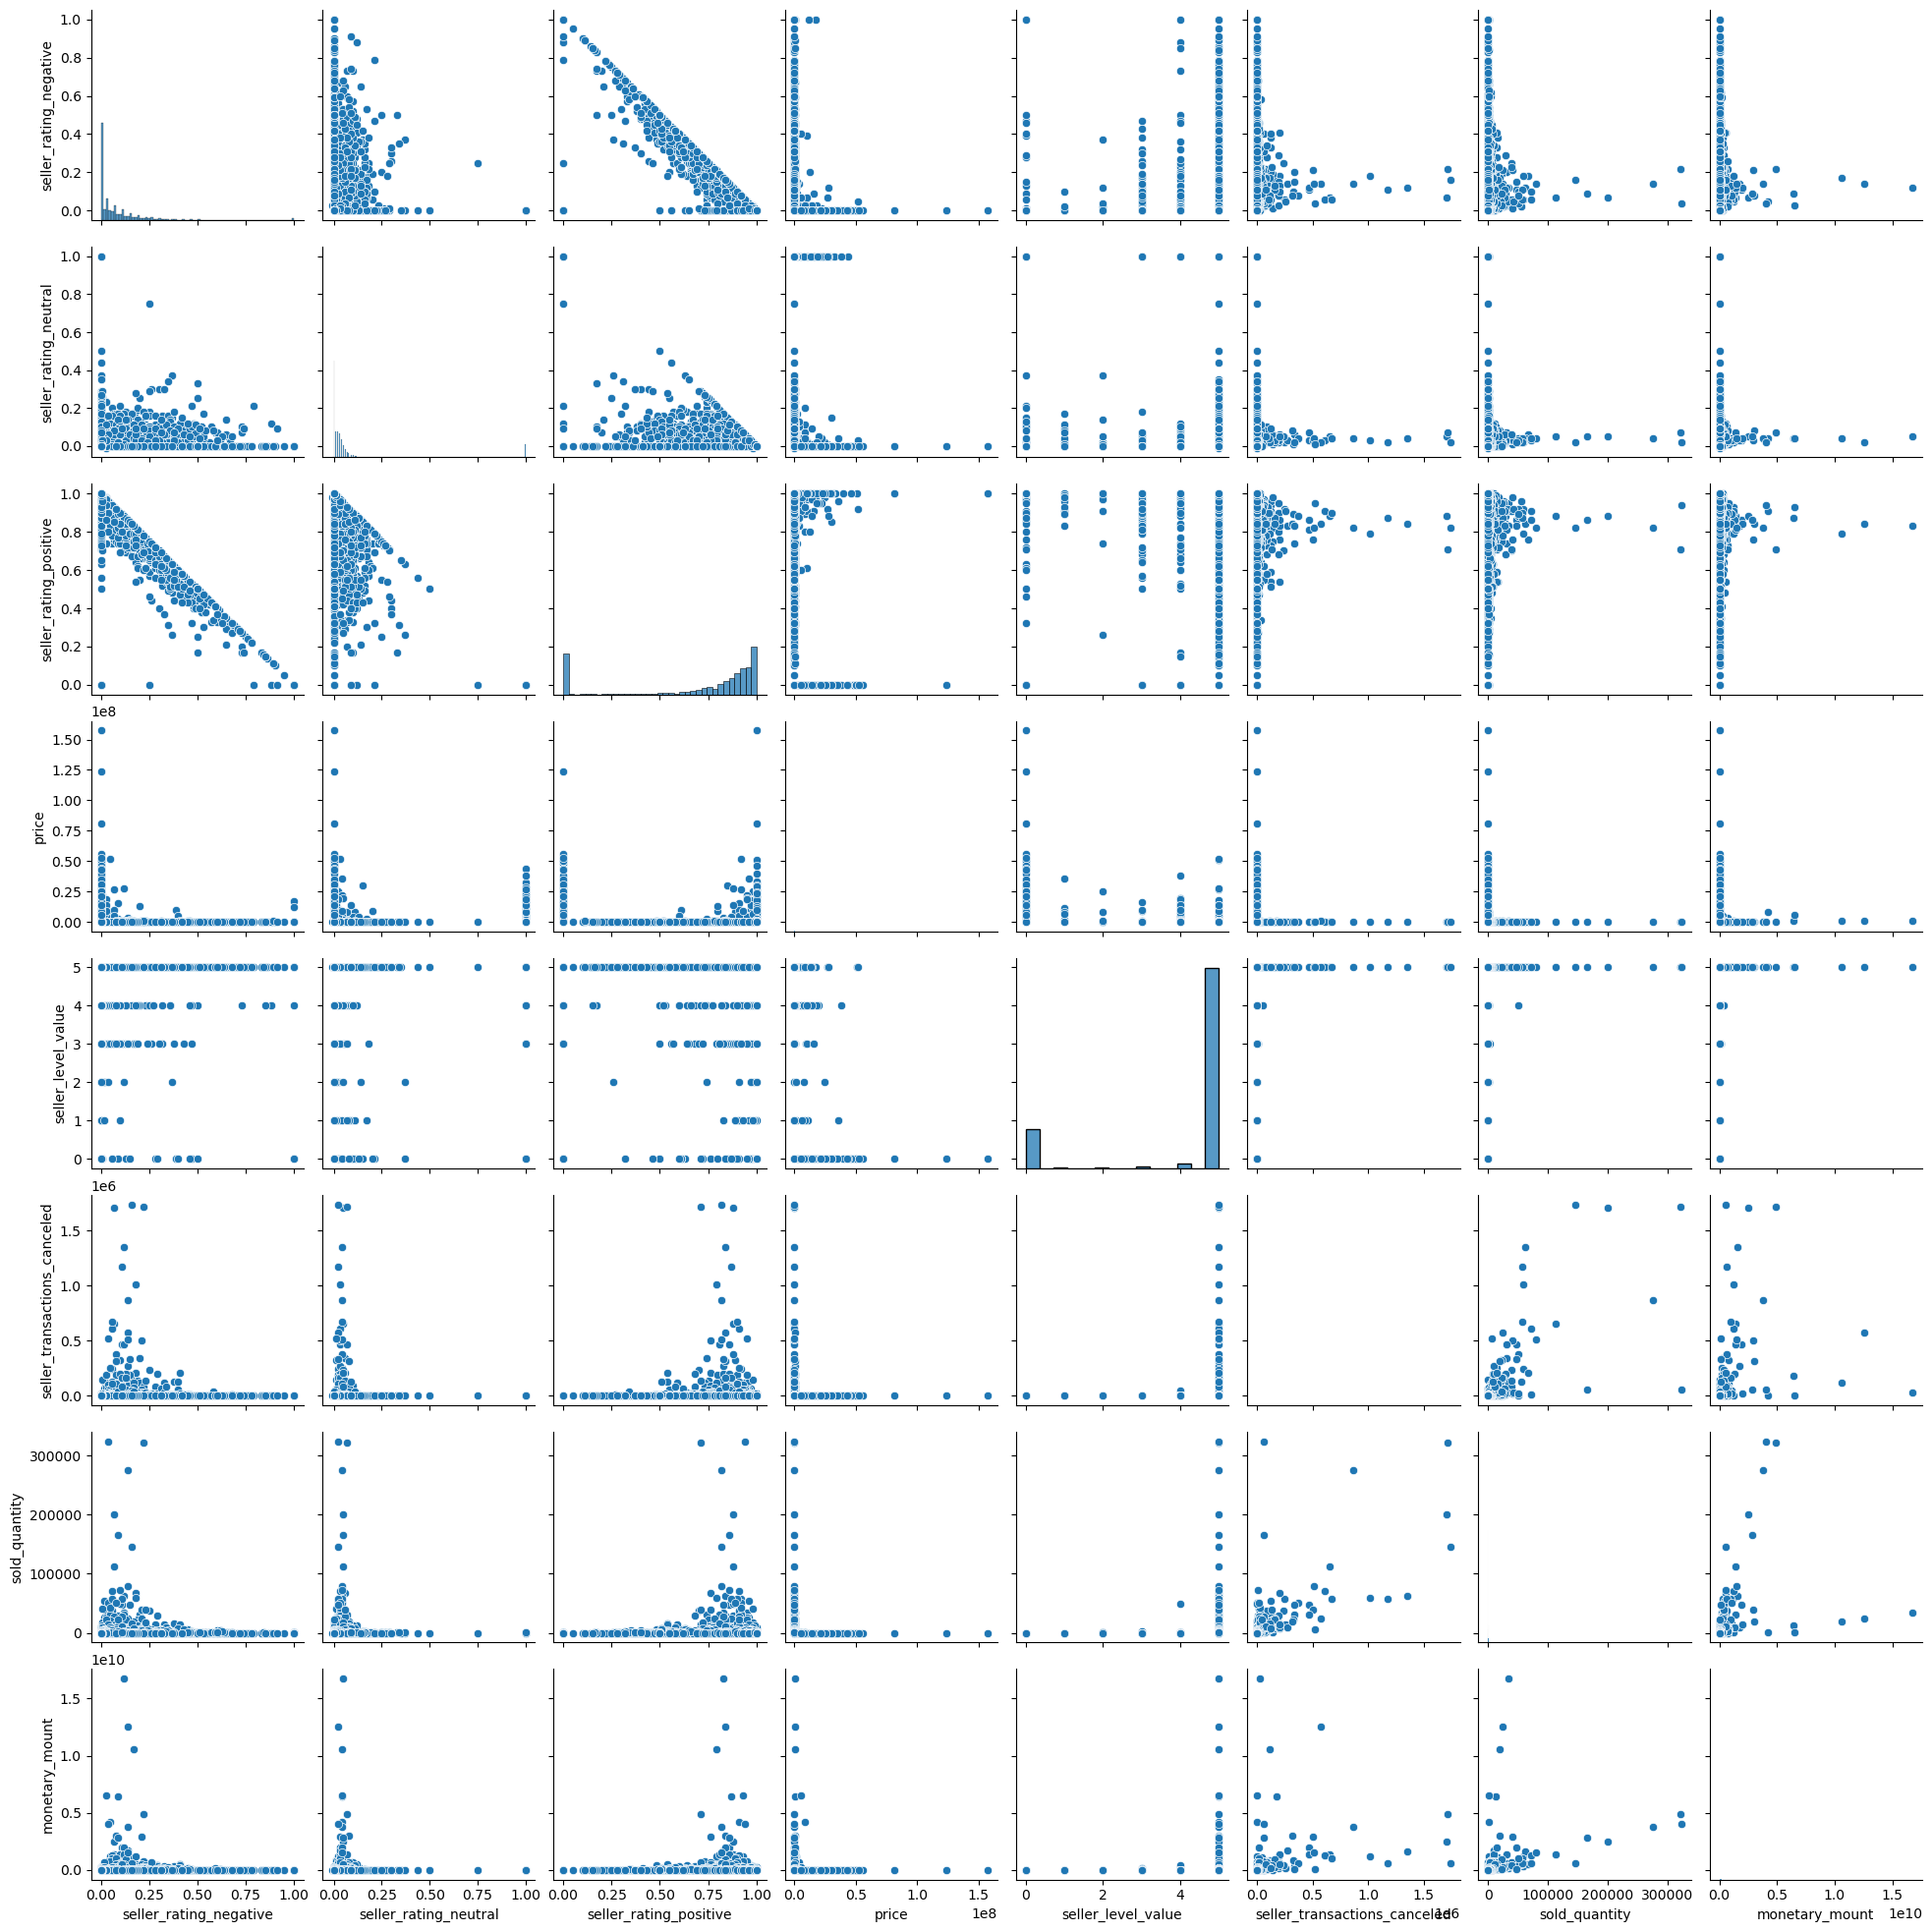

In [30]:
sns.pairplot(group_by_seller)


Según el gráfico anterior podemos ver que existe una clara diferencia entre las escalas de los valores obtenidos.

Como la idea es generar cluster que nos permitan generar grupos de sellers necesitamos que los datos estén normalizados. Para esto seleccionamos las variables a tratar y se le aplica la normalización al dataframe.

In [32]:
col_to_norm = ['seller_rating_negative',
               'seller_rating_neutral',
               'seller_rating_positive',
               'monetary_mount',
               'seller_level_value',
               'seller_transactions_canceled',
               'sold_quantity']

scaler = MinMaxScaler()
norm_sellers = scaler.fit_transform(group_by_seller[col_to_norm])

### Segmentación 

Con los datos ya normalizados, generamos varios clusters para obtener el números de clúster optimo.
Para esto obtener el valor de inercia de KMeans (o SSE), calcula la suma de las distancias de todos los puntos dentro de un grupo desde el centroide del punto.

In [33]:
sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0)
    kmeans.fit(norm_sellers)
    sse.append(kmeans.inertia_) 

Presentamos los resultados para ver valor que necesitamos.

Text(0, 0.5, 'sse')

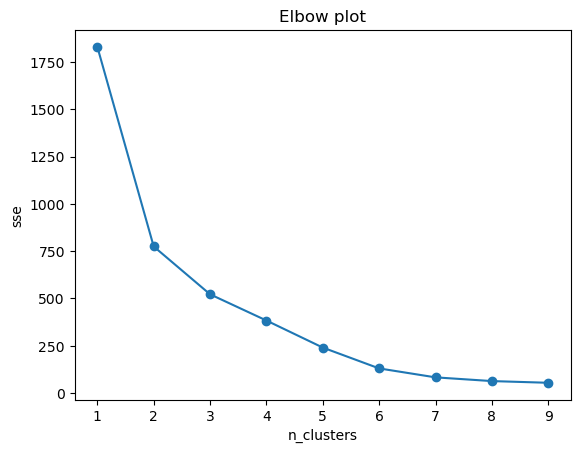

In [34]:
plt.plot(range(1, 10), sse, marker='o')
plt.title('Elbow plot')
plt.xlabel('n_clusters')
plt.ylabel('sse')

Se puede observar que desde el número de cluster 3 aproximadamente en adelante se mantiene la variación por l o que tomamos ese valor como el número optimo.

Generamos el cluster con ese número y asignamos el id cluster asociado a cada registro de los datos.

In [35]:
sellers_kmeans = KMeans(n_clusters=3, n_init='auto', random_state=0)
sellers_kmeans.fit(norm_sellers)
group_by_seller['cluster_id'] = sellers_kmeans.labels_

Seleccionamos las variables que utilizamos para la segmentación y agrupamos por cluster para el análisis.

In [36]:
col_to_norm = ['seller_rating_negative',
               'seller_rating_neutral',
               'seller_rating_positive',
               'monetary_mount',
               'seller_level_value',
               'seller_transactions_canceled',
               'sold_quantity']

cluster_mean = group_by_seller.groupby('cluster_id')[col_to_norm].mean().reset_index()

### Análisis de resultamos

Como se puede apreciar en los cluster generados existen marcadas diferencias entre cada grupo.



In [37]:
cluster_mean.head()

,cluster_id,seller_rating_negative,seller_rating_neutral,seller_rating_positive,monetary_mount,seller_level_value,seller_transactions_canceled,sold_quantity
0,0,0.096799,0.027788,0.875412,5.309493e+07,4.949509,7848.586475,1901.409184
1,1,0.008025,0.160056,0.191066,4.606914e+03,0.008979,0.269360,0.497194
2,2,0.333596,0.600974,0.065431,2.104571e+06,4.891386,303.048689,103.116105


- El primer grupo tiene una alta proporción de valoraciones positivas (87.54%), una proporción relativamente baja de valoraciones neutrales (2.78%), y una proporción baja de valoraciones negativas (9.68%). El monto monetario es muy alto (alrededor de 53 millones), lo que sugiere que los vendedores en este grupo manejan transacciones de gran valor. Además, tienen un alto nivel de vendedor dentro de la plataforma (cercano a 5). Algo que llama la atención es el alto numero de transacciones canceladas (7848) pero esto parece no afectar al performance del grupo. En este grupo podemos apreciar a vendedores que que tienen comportamiento ideal con sus clientes ya que a pesar del número alto de ventas canceladas los clientes siguen entregándole una calificación elevada a su tiendas, ademas de generar un gran valor monetaria a la plataforma.

- El segundo grupo tiene una baja proporción de valoraciones negativas (0.80%), una proporción moderada de valoraciones neutrales (16.01%), y una proporción baja de valoraciones positivas (19.11%). El monto monetario es bastante bajo (alrededor de 4606), lo que sugiere que los vendedores en este grupo manejan transacciones de menor valor. Además, tienen un nivel de vendedor muy bajo (cercano a 0) y han cancelado un número bajo de transacciones (0.27). Al parecer este grupo corresponde a un tipo de vendedor ocasional que no tiene tiendas y no genera gran cantidad de ganancias a la plataforma.

- El tercer grupo tiene una alta proporción de valoraciones negativas de vendedores (33.36%), una proporción muy alta de valoraciones neutrales (60.10%), y una proporción baja de valoraciones positivas (6.54%). El monto monetario es significativo (alrededor de 2.1 millones), lo que sugiere que los vendedores en este grupo manejan transacciones de valor considerable. Tienen un alto nivel de vendedor (cercano a 5) y han cancelado una cantidad considerable de transacciones (303). En este grupo se aprecian vendedores que si bien generan un valor considerable de ventas no tienen un comportamiento ideal con sus clientes ya que estos le entregan un bajo valor calificación y tienen un valor considerable de transacciones canceladas.


### Conclusiones

Según los datos presentados anteriormente el grupo que más le puede entregar valor a MeLi es el primer grupo por su buena calificación por parte de los clientes y por su alto monto monetario generado en ventas.

In [59]:
best_group = group_by_seller[group_by_seller['cluster_id'] == 0].copy()

Para seleccionar a los mejores vemos que valores son los que presentan mayor dispersión para tomarlos como referencia y ordenar el dataset

In [60]:
best_group.std()

seller_rating_negative          1.126205e-01
seller_rating_neutral           3.469833e-02
seller_rating_positive          1.223525e-01
price                           1.694192e+06
seller_level_value              3.155917e-01
seller_transactions_canceled    6.473437e+04
sold_quantity                   1.057159e+04
monetary_mount                  4.245760e+08
cluster_id                      0.000000e+00
dtype: float64

Según lo anterior podemos ver que el precio, la cantidad de ventas y el monto monetario son los que presentan mayor dispersión, el resto de valores presentan baja dispersión por lo que no los tomaremos en cuenta para la selección final. 

Si los ordenamos **monetary_mount** que es la mezcla entre **price** y **sold_quantity** podríamos mejorar la selección de mejores sellers dentro del grupo.

In [61]:
best_group.sort_values(['monetary_mount'], inplace=True, ascending=False)

Para seleccionar a los mejores podemos tomar todos los seller que están sobre el percentil 75 y de esta manera tomamos los tienen mejor performance dentro del mejor grupo.

In [62]:
best_group.monetary_mount.describe()

count    4.377000e+03
mean     5.309493e+07
std      4.245760e+08
min      0.000000e+00
25%      7.950000e+05
50%      5.055000e+06
75%      2.159096e+07
max      1.675329e+10
Name: monetary_mount, dtype: float64

In [63]:
len(best_group[best_group['monetary_mount'] > 2.159096e+07])

1095

Finalmente tenemos los mejores mil sellers dentro de la selección de datos que sacamos desde la api.